In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='darkgrid', palette='pastel')
sns_context = sns.set_context('paper', font_scale=1.25)
sns.set_palette('deep')
sns_context

In [56]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [57]:
f'{train.shape}, {test.shape}'

'(58645, 13), (39098, 12)'

In [58]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [59]:
train['cb_person_default_on_file'].replace({'N':0, 'Y':1}, inplace=True)
test['cb_person_default_on_file'].replace({'N':0, 'Y':1}, inplace=True)

In [60]:
train.isna().sum() # no hay nulos

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

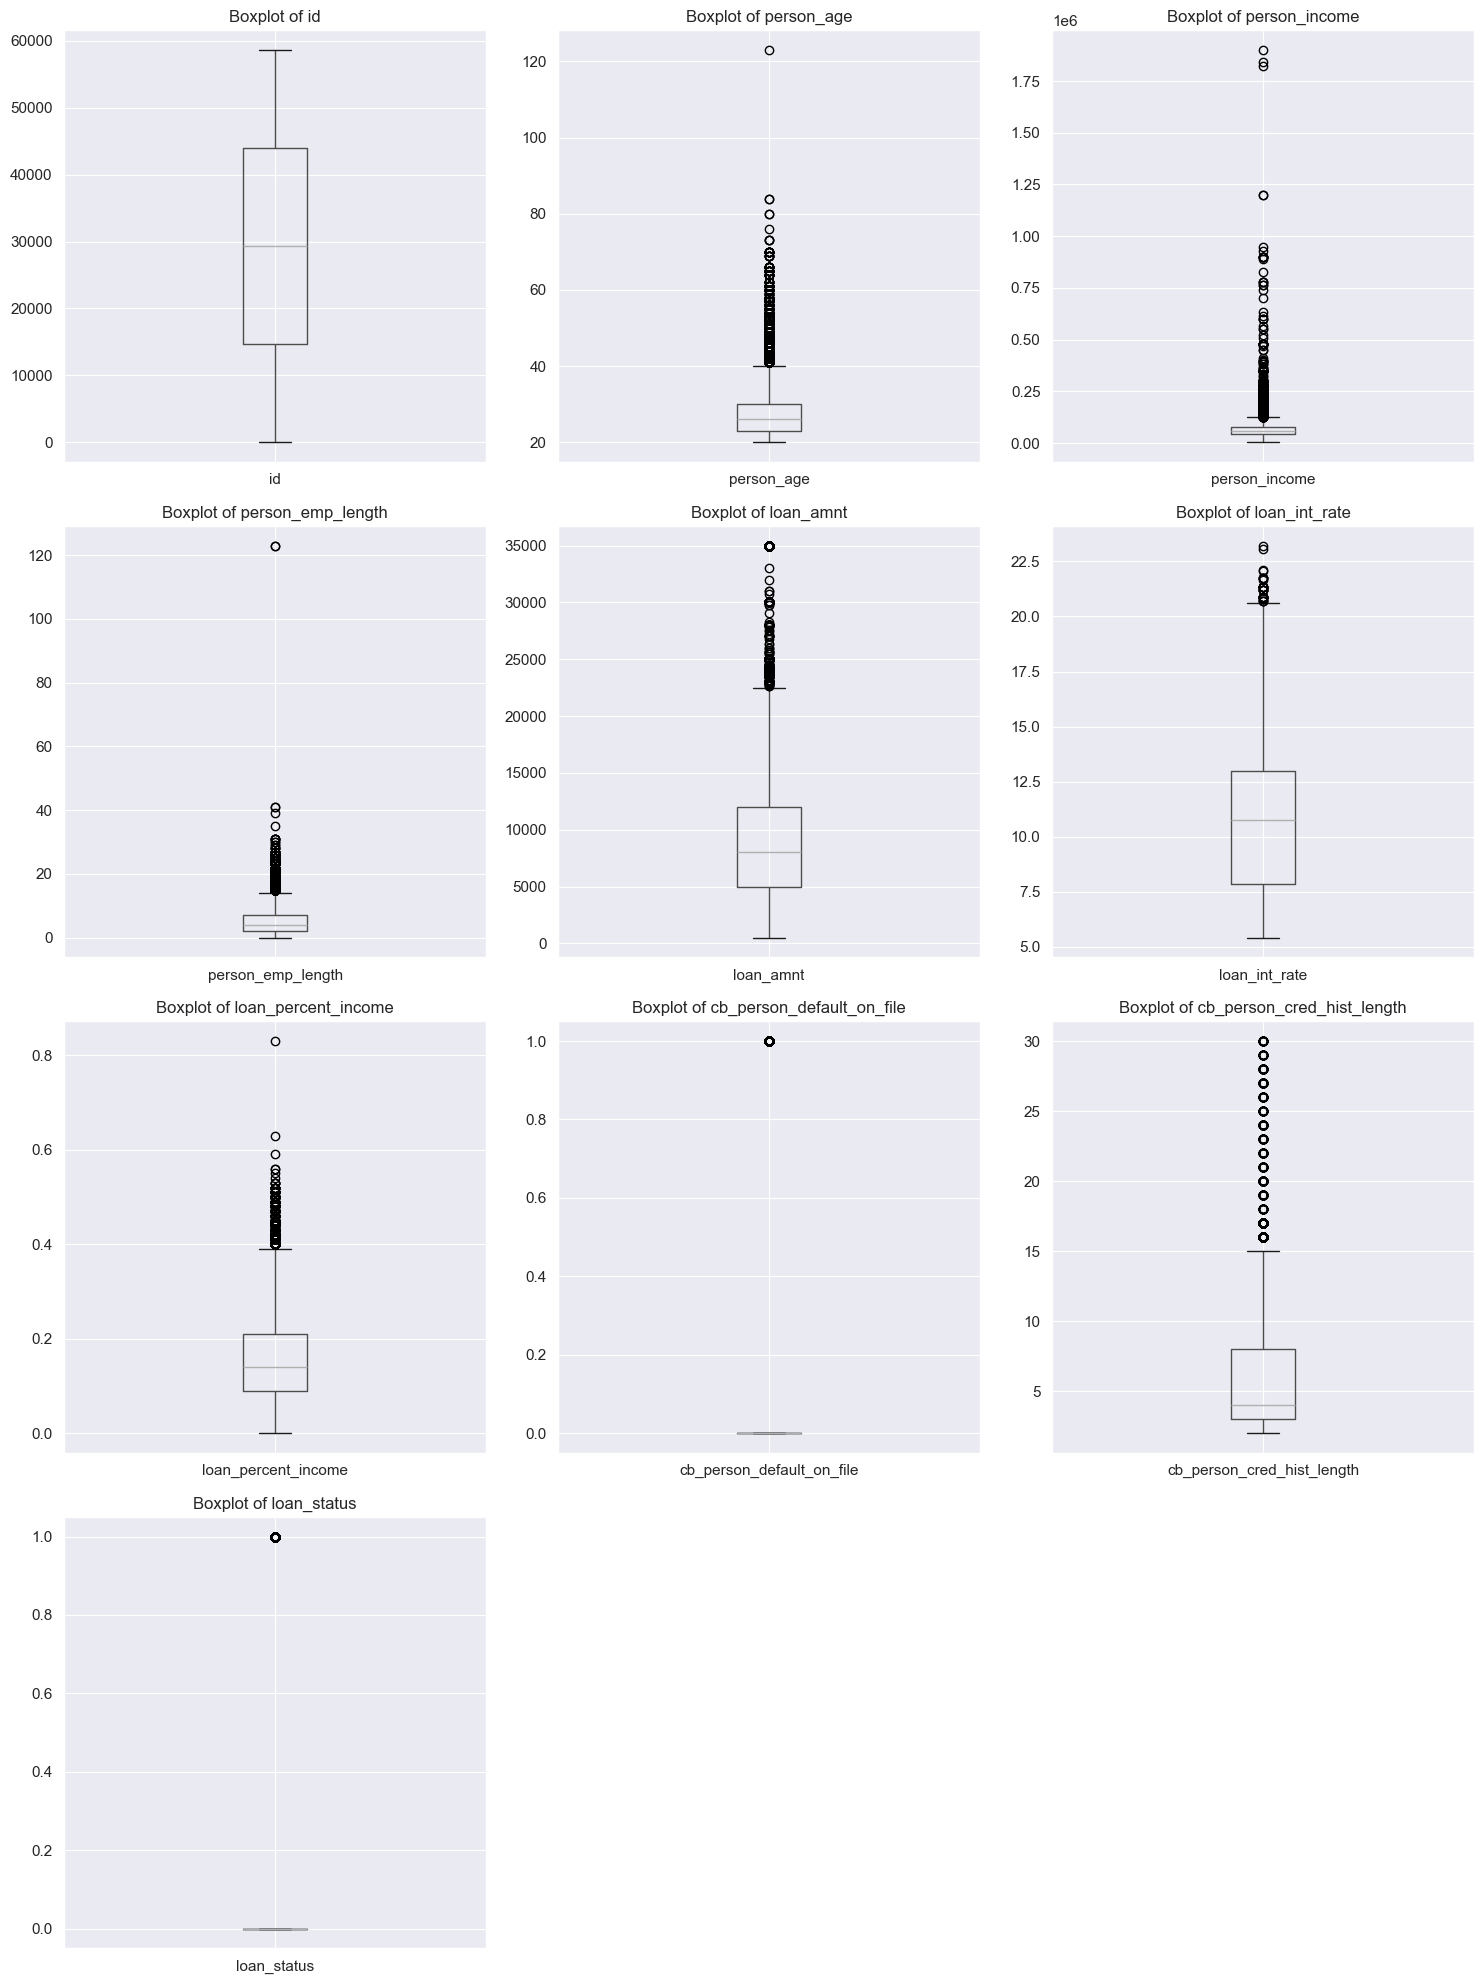

In [61]:
numerical_cols = train.select_dtypes(include=['number']).columns

# Configurar el tamaño de los subplots
num_plots = len(numerical_cols)
cols = 3  # Cantidad de subplots por fila
rows = (num_plots + cols - 1) // cols  # Calcular filas necesarias

# Crear subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Aplanar para facilitar la iteración

for i, col in enumerate(numerical_cols):
    train.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Ocultar subplots vacíos si hay más espacios que gráficos
for j in range(num_plots, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [62]:
train = train[(train['person_income'] < 1000000) & (train['person_age'] < 100) & (train['person_emp_length'] < 100)] # Eliminamos los outliers extremos
train.reset_index(inplace=True, drop=True)

Text(0.5, 1.0, 'Distribucion de person_income por loan_status')

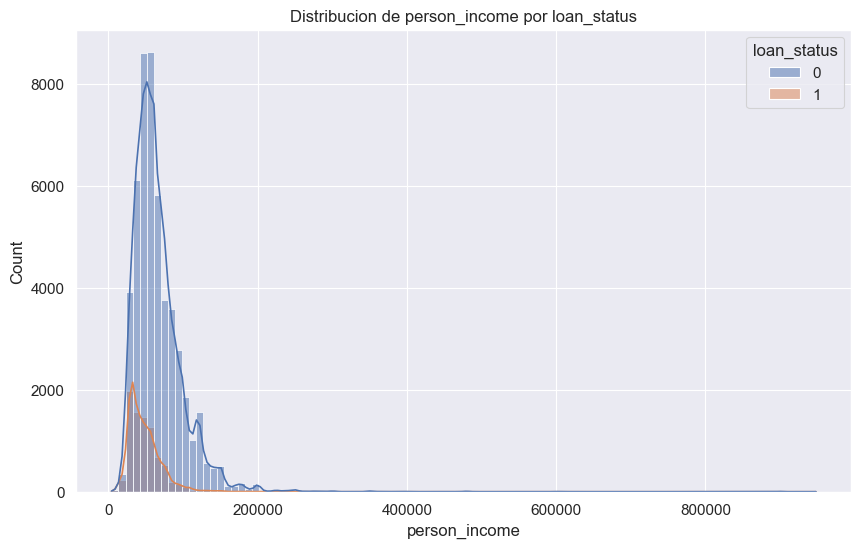

In [63]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='person_income', hue='loan_status', bins=100, kde=True)
plt.title('Distribucion de person_income por loan_status') # Podemos remover los casos con income > 1000000 ya que no afectaria a la distribucion y lo podemos considerar un outlier extremo

Text(0.5, 1.0, 'Distribucion de person_emp_length por loan_status')

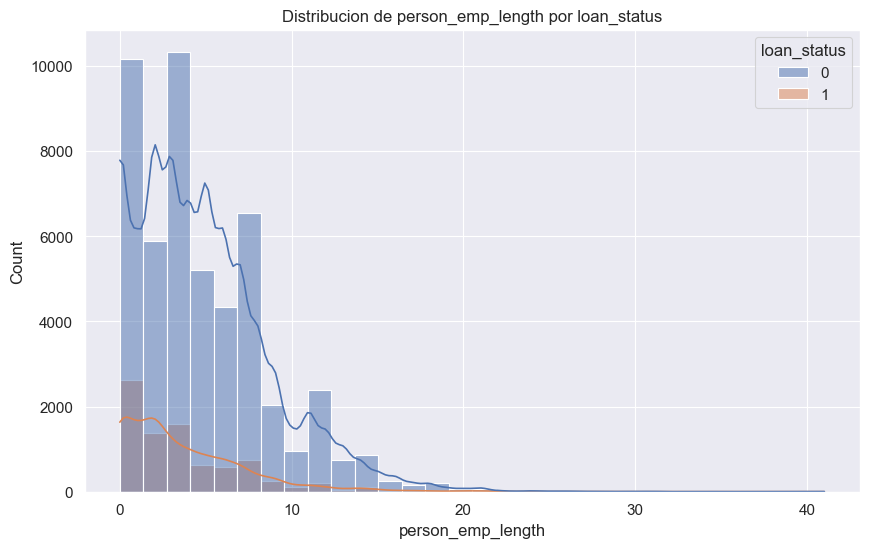

In [64]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='person_emp_length', hue='loan_status', bins=30, kde=True)
plt.title('Distribucion de person_emp_length por loan_status') # Tambien, hay un caso donde tiene un tiempo de trabajo de 123 anios, lo podemos remover

Text(0.5, 1.0, 'Distribucion de person_age por loan_status')

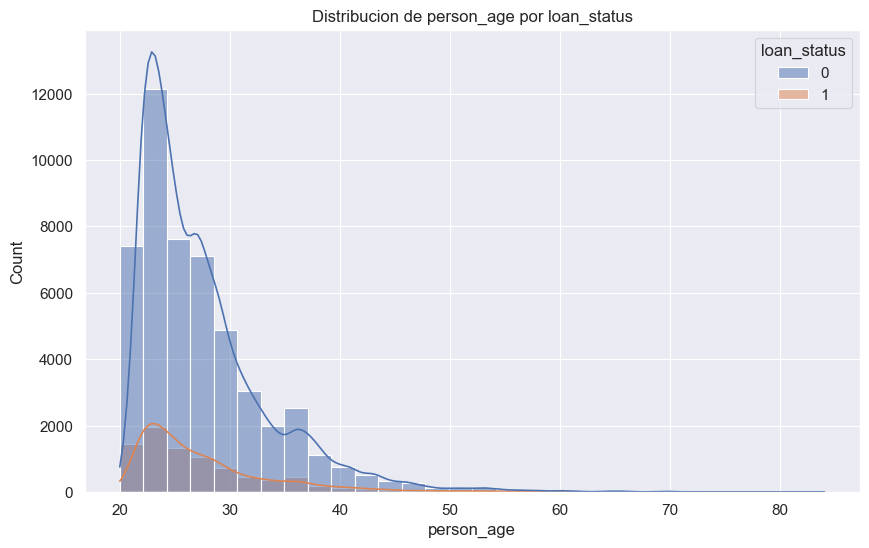

In [65]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x='person_age', hue='loan_status', bins=30, kde=True)
plt.title('Distribucion de person_age por loan_status')

<Axes: >

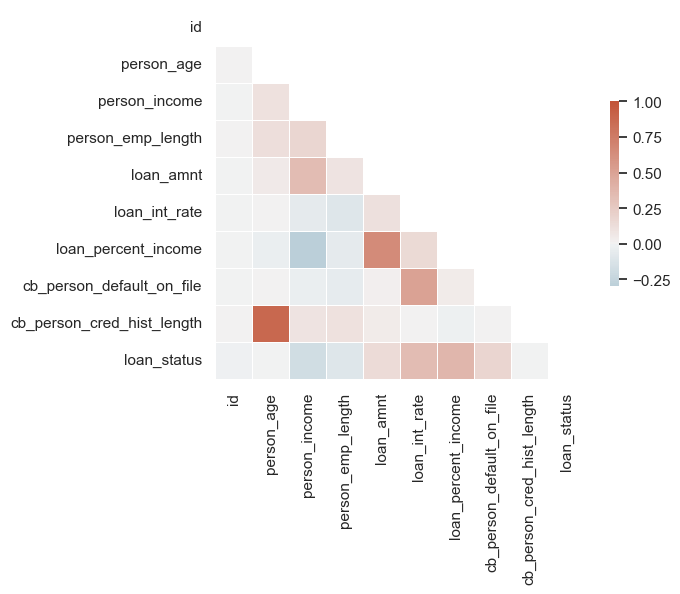

In [66]:
sns.set_theme(style='white')

df_num = train.select_dtypes(include=['number'])

corr = df_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

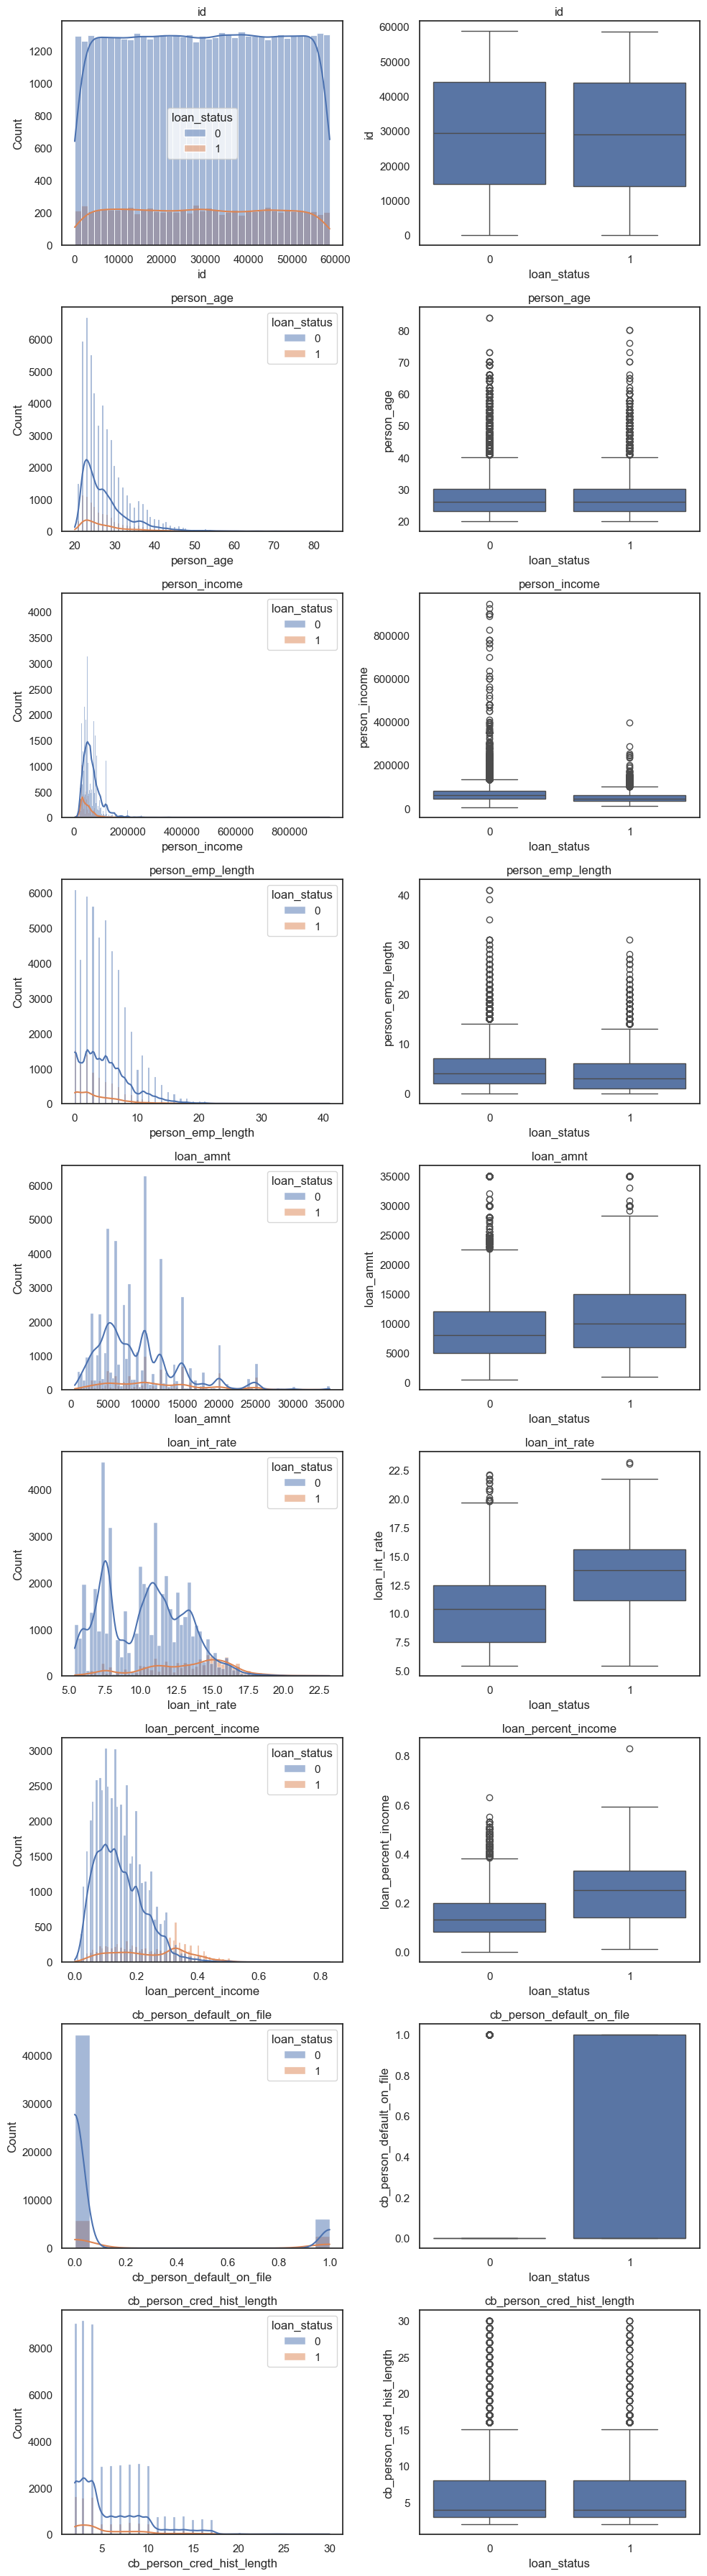

In [67]:
def create_bivariate_plots_numerical(df, target_column):
    
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if target_column in numerical_cols:
        numerical_cols.remove(target_column)
    
    # setting up the matplotlib figure
    n_rows = len(numerical_cols)  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
    
    # flatten the axes array for easy iteration
    #axes = axes.flatten()
    
    # creating bivariate plots
    for i, col in enumerate(numerical_cols):
        # Create a histogram
        sns.histplot(data=df, x=col, hue=target_column, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'{col}')
        
        # Create a boxplot beside the histogram
        sns.boxplot(data=df, y=col, x=target_column, ax=axes[i, 1])
        axes[i, 1].set_title(f'{col}')
    
    plt.tight_layout()
    plt.show()

create_bivariate_plots_numerical(train, 'loan_status')

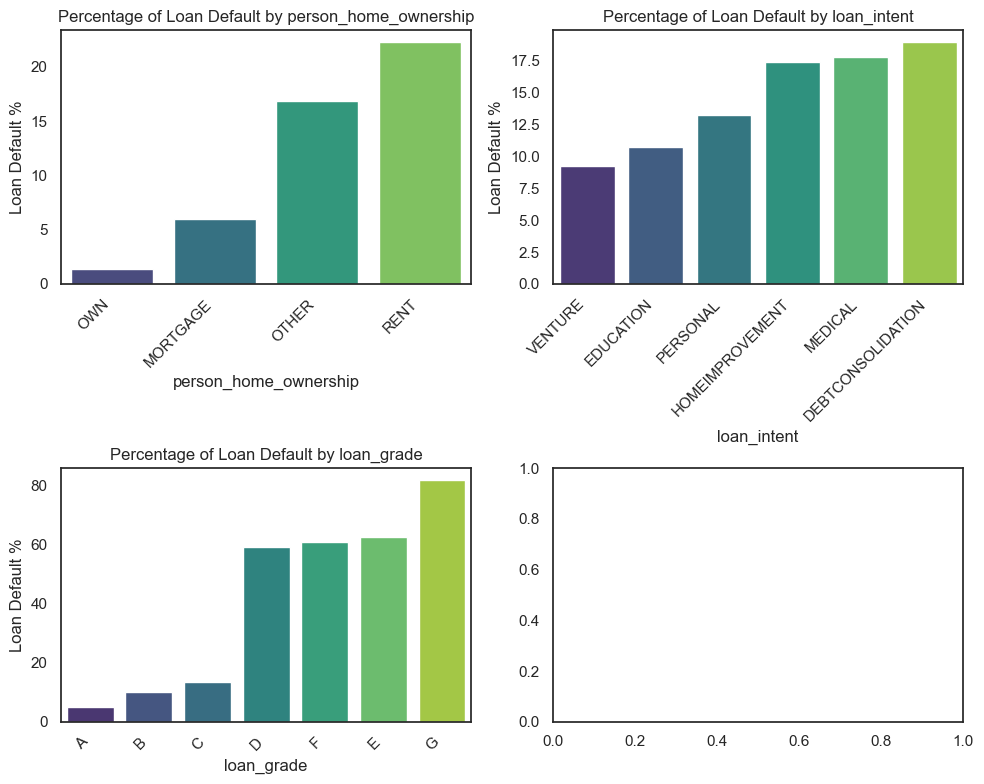

In [68]:
def create_bivariate_plots_categorical(df, target_column):
    
    # selecting categorical column names
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_column in categorical_cols:
        categorical_cols.remove(target_column)

    # setting up the matplotlib figure
    n_rows = int(np.ceil(len(categorical_cols)/2))  # One row for each numerical column
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 4))
    
    # flatten the axes array for easy iteration
    axes = axes.flatten()
    
    for i, col in enumerate(categorical_cols):
        # calculating the percentage of positive target variable for each category
        percentage_df = df.groupby(col)[target_column].mean().sort_values().reset_index()
        percentage_df[target_column] = percentage_df[target_column] * 100  # convert to percentage

        # creating bar plots
        sns.barplot(data=percentage_df, x=col, y=target_column, ax = axes[i], palette='viridis')
        axes[i].set_title(f'Percentage of Loan Default by {col}')
        axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(f'Loan Default %')
        
    plt.tight_layout()
    plt.show()

create_bivariate_plots_categorical(train, 'loan_status')

## Feature Engineering

In [69]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,0,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,0,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,0,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,0,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,0,3,0


In [70]:
# Hay casos donde emp_length es 0, reemplazamos con la media
train['person_emp_length'] = train['person_emp_length'].replace(0, train['person_emp_length'].mean())
test['person_emp_length'] = test['person_emp_length'].replace(0, test['person_emp_length'].mean())

In [71]:
def feature_creation(df):
    df['income_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['age_category'] = pd.cut(df['person_age'], bins=[19, 30, 55, 100], labels=['young-adult','adult','senior'])
    df['emp_length_group'] = pd.cut(df['person_emp_length'], bins=[-1,5,10,15,100], labels=['junior', 'semi-senior', 'senior', 'expert'])
    df['int_rate_group'] = pd.cut(df['loan_int_rate'], bins=[0,10,20,30,40,50,60,70,80,90,100], labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100'])
    df['age_income_ratio'] = df['person_age'] / df['person_income']
    df['age_emp_ratio'] = df['person_age'] / df['person_emp_length']
    df['age_loan_ratio'] = df['person_age'] / df['loan_amnt']
    return df

In [72]:
train = feature_creation(train)
test = feature_creation(test)

In [73]:
train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_loan_ratio,age_category,emp_length_group,int_rate_group,age_income_ratio,age_emp_ratio,age_loan_ratio
0,0,37,35000,RENT,4.696796,EDUCATION,B,6000,11.49,0.17,0,14,0,5.833333,adult,junior,10-20,0.001057,7.877711,0.006167
1,1,22,56000,OWN,6.000000,MEDICAL,C,4000,13.35,0.07,0,2,0,14.000000,young-adult,semi-senior,10-20,0.000393,3.666667,0.005500
2,2,29,28800,OWN,8.000000,PERSONAL,A,6000,8.90,0.21,0,10,0,4.800000,young-adult,semi-senior,0-10,0.001007,3.625000,0.004833
3,3,30,70000,RENT,14.000000,VENTURE,B,12000,11.11,0.17,0,5,0,5.833333,young-adult,senior,10-20,0.000429,2.142857,0.002500
4,4,22,60000,RENT,2.000000,MEDICAL,A,6000,6.92,0.10,0,3,0,10.000000,young-adult,junior,0-10,0.000367,11.000000,0.003667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58632,58640,34,120000,MORTGAGE,5.000000,EDUCATION,D,25000,15.95,0.21,1,10,0,4.800000,adult,junior,10-20,0.000283,6.800000,0.001360
58633,58641,28,28800,RENT,4.696796,MEDICAL,C,10000,12.73,0.35,0,8,1,2.880000,young-adult,junior,10-20,0.000972,5.961511,0.002800
58634,58642,23,44000,RENT,7.000000,EDUCATION,D,6800,16.00,0.15,0,2,1,6.470588,young-adult,semi-senior,10-20,0.000523,3.285714,0.003382
58635,58643,22,30000,RENT,2.000000,EDUCATION,A,5000,8.90,0.17,0,3,0,6.000000,young-adult,junior,0-10,0.000733,11.000000,0.004400


In [74]:
test

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,income_loan_ratio,age_category,emp_length_group,int_rate_group,age_income_ratio,age_emp_ratio,age_loan_ratio
0,58645,23,69000,RENT,3.000000,HOMEIMPROVEMENT,F,25000,15.76,0.36,0,2,2.760000,young-adult,junior,10-20,0.000333,7.666667,0.000920
1,58646,26,96000,MORTGAGE,6.000000,PERSONAL,C,10000,12.68,0.10,1,4,9.600000,young-adult,semi-senior,10-20,0.000271,4.333333,0.002600
2,58647,26,30000,RENT,5.000000,VENTURE,E,4000,17.19,0.13,1,2,7.500000,young-adult,junior,10-20,0.000867,5.200000,0.006500
3,58648,33,50000,RENT,4.000000,DEBTCONSOLIDATION,A,7000,8.90,0.14,0,7,7.142857,adult,junior,0-10,0.000660,8.250000,0.004714
4,58649,26,102000,MORTGAGE,8.000000,HOMEIMPROVEMENT,D,15000,16.32,0.15,1,4,6.800000,young-adult,semi-senior,10-20,0.000255,3.250000,0.001733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39093,97738,22,31200,MORTGAGE,2.000000,DEBTCONSOLIDATION,B,3000,10.37,0.10,0,4,10.400000,young-adult,junior,10-20,0.000705,11.000000,0.007333
39094,97739,22,48000,MORTGAGE,6.000000,EDUCATION,A,7000,6.03,0.15,0,3,6.857143,young-adult,semi-senior,0-10,0.000458,3.666667,0.003143
39095,97740,51,60000,MORTGAGE,4.687068,PERSONAL,A,15000,7.51,0.25,0,25,4.000000,adult,junior,0-10,0.000850,10.881002,0.003400
39096,97741,22,36000,MORTGAGE,4.000000,PERSONAL,D,14000,15.62,0.39,1,4,2.571429,young-adult,junior,10-20,0.000611,5.500000,0.001571


In [75]:
# from category_encoders import TargetEncoder
# from feature_engine.encoding import CountFrequencyEncoder
# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.compose import ColumnTransformer
# import pathlib
# import joblib 

# def trans_factores(df,vars_cat,var_clase):
#     ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
#     frecuency_transformer = CountFrequencyEncoder(encoding_method='frequency')
#     target_encoder = TargetEncoder()

#     preprocess = ColumnTransformer(
#     transformers=[
#     ('ordinal_encoder', ordinal_encoder, vars_cat),
#     ('frecuency_transformer', frecuency_transformer, vars_cat),
#     ('target_encoder', target_encoder, vars_cat)
#     ], remainder='passthrough') 

#     train_features = preprocess.fit_transform(df[vars_cat],df[var_clase])

#     pathlib.Path(f"preprocessing").mkdir(parents=True, exist_ok=True)
#     _=joblib.dump(preprocess, 'preprocessing/transformer.joblib')
    
#     #Renombramos variables codificadas
#     vars_cat_cols=[s + '_ordinal' for s in vars_cat]
#     vars_cat_cols=vars_cat_cols+[s + '_freq' for s in vars_cat]
#     vars_cat_cols=vars_cat_cols+[s + '_target' for s in vars_cat]
#     df2=df.copy()
#     df2.drop(columns=vars_cat,axis=1,inplace=True)
#     df2=pd.concat([df2,pd.DataFrame(train_features,columns=vars_cat_cols)],axis=1)
#     return(df2)

In [76]:
# vars_cat = ['person_home_ownership', 'loan_intent', 'loan_grade', 'age_category', 'emp_length_group']
# var_clase='loan_status'
# train = trans_factores(train,vars_cat,var_clase)

In [77]:
train

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,income_loan_ratio,age_category,emp_length_group,int_rate_group,age_income_ratio,age_emp_ratio,age_loan_ratio
0,0,37,35000,RENT,4.696796,EDUCATION,B,6000,11.49,0.17,0,14,0,5.833333,adult,junior,10-20,0.001057,7.877711,0.006167
1,1,22,56000,OWN,6.000000,MEDICAL,C,4000,13.35,0.07,0,2,0,14.000000,young-adult,semi-senior,10-20,0.000393,3.666667,0.005500
2,2,29,28800,OWN,8.000000,PERSONAL,A,6000,8.90,0.21,0,10,0,4.800000,young-adult,semi-senior,0-10,0.001007,3.625000,0.004833
3,3,30,70000,RENT,14.000000,VENTURE,B,12000,11.11,0.17,0,5,0,5.833333,young-adult,senior,10-20,0.000429,2.142857,0.002500
4,4,22,60000,RENT,2.000000,MEDICAL,A,6000,6.92,0.10,0,3,0,10.000000,young-adult,junior,0-10,0.000367,11.000000,0.003667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58632,58640,34,120000,MORTGAGE,5.000000,EDUCATION,D,25000,15.95,0.21,1,10,0,4.800000,adult,junior,10-20,0.000283,6.800000,0.001360
58633,58641,28,28800,RENT,4.696796,MEDICAL,C,10000,12.73,0.35,0,8,1,2.880000,young-adult,junior,10-20,0.000972,5.961511,0.002800
58634,58642,23,44000,RENT,7.000000,EDUCATION,D,6800,16.00,0.15,0,2,1,6.470588,young-adult,semi-senior,10-20,0.000523,3.285714,0.003382
58635,58643,22,30000,RENT,2.000000,EDUCATION,A,5000,8.90,0.17,0,3,0,6.000000,young-adult,junior,0-10,0.000733,11.000000,0.004400


In [78]:
# feature_creation(test)
# preprocess = joblib.load('preprocessing/transformer.joblib')
# test_features = preprocess.transform(test)

# vars_cat_cols=[s + '_ordinal' for s in vars_cat]
# vars_cat_cols=vars_cat_cols+[s + '_freq' for s in vars_cat]
# vars_cat_cols=vars_cat_cols+[s + '_target' for s in vars_cat]
# test_mod=pd.concat([test,pd.DataFrame(test_features,columns=vars_cat_cols)],axis=1)
# test_mod.drop(columns=vars_cat,axis=1,inplace=True)
# test_mod

In [79]:
train.to_csv('./data/train_mod.csv',index=False)
test.to_csv('./data/test_mod.csv',index=False)